<p></p>

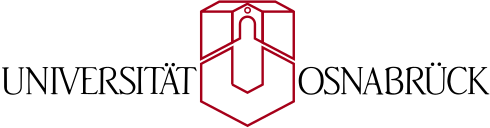
# <center>Einführung in die Künstliche Intelligenz</center> <a class="tocSkip">
### <center>Wintersemester 2020/21</center> <a class="tocSkip">
<center>Prof. Dr. Joachim Hertzberg, Felix Igelbrink, Alexander Mock</center>

# Übungsblatt 4: Spielbäume

## Programmieraufgabe: 2048 mit Minimax

In dieser Aufgabe werden wir die Spiellogik für das Spiel [2048](https://de.wikipedia.org/wiki/2048_(Computerspiel)) aus dem ersten Übungsblatt wieder aufgreifen.
Allerdings werden Sie nun mit Ihrem Wissen aus der Vorlesung eine einfache KI auf Basis des Minimax-Algorithmus implementieren.
Beantworten Sie zur Vorbereitung zunächst die folgenden Fragen:

### 
Der Minimax-Algorithmus ist eigentlich für 2 gegeneinander spielende Spieler ausgelegt. 2048 wird jedoch allein gespielt. Erläutern Sie, wie das Spiel trotzdem mit Minimax gespielt werden kann. Wer ist der minimierende, wer der maximierende Spieler?

YOUR ANSWER HERE

### 
Entwerfen Sie eine geeignete Bewertungsfunktion für einen Spielzustand und erläutern Sie Ihre Überlegungen. 

*Hinweis*: Um die Laufzeit des Algorithmus gering zu halten, sollten Sie dabei versuchen eine möglichst einfache Funktion zu finden.

YOUR ANSWER HERE

### 
Erweitern Sie die unten gegebene Programmiervorlage um die nötigen Funktionen zur Bewertung des Spielzustandes. Erweitern Sie außerdem die `Board2048`- Klasse um die Ermittlung der möglichen Züge für beide "Spieler". 

*Hinweis*: Selbstverständlich können Sie auch Ihre eigene Implementation der Spiellogik von Blatt 0 als Ausgangsbasis verwenden.

In [ ]:
import numpy as np
from enum import IntEnum


class Action(IntEnum):
    """
    Represents the possible actions as ints. 
    Note, that the order of the items should not be changed, 
    as they indictate the number of rotations necessary for the sliding step.
    """
    left = 0
    up = 1
    right = 2
    down = 3


class Board2048(object):
    def __init__(self, width: int =4, height: int =4, seed=None):
        """
        Represents a 2048 board with width and height. Actions can be performed on the board 
        with the step() function.
        
        Parameters
        ----------
        with: int
            The width of the board
        height: int
            The height of the board
        seed: any
            The seed for the random state. Using the same seed will result in the same game to be played
        """
        self.width: int = width
        self.height: int = height
        self.score: int = 0
            
        # Internal Variables
        self.board = None
        self.np_random = None

        self.seed(seed=seed)
        self.reset()
        

    def seed(self, seed=None):
        """
        Seed the random state.
        
        Parameters
        ----------
        seed: any
            The seed for the random state. Using the same seed will result in the same game to be played
        """
        
        self.np_random = np.random.RandomState(seed=seed)
        return [seed]

    def step(self, action: Action):
        """
        Perform one action on the board. 
        Possible actions are [left, right, up, down]. 
        Note, that impossible actions will result in no board change.
        
        Parameters
        ----------
        action: Action
            The action to perform

        Returns
        -------
        board: array_like
            The new board state
        score: int
            The gained score from this move
        game_over: bool
            Is the game over?
        dict: dict
            Currently unused (but expected by the test code later!)
        """

        game_over = False
        new_board, score = self.do_action(action)
        if np.any(new_board != self.board):
            # Place one random tile on empty location
            self._place_random_tiles(new_board, count=1)
        self.board = new_board
        game_over = self.game_over()

        self.score += score
        
        return self.board, score, game_over, {}
    
    def do_action(self, action):
        # Align board action with left action
        rotated_obs = np.rot90(self.board, k=action)
        score, updated_obs = self._slide_and_merge(rotated_obs)
        return np.rot90(updated_obs, k=4 - action), score

    def game_over(self, who: str = 'max'):
        """
        Check if the game is over.

        Returns
        -------
        game_over: bool
            True if the game is over, False otherwise
        """
        
        if who == 'max':
            copy_board = self.board.copy()

            if not copy_board.all():
                return False

            for action in Action:
                rotated_obs = np.rot90(copy_board, k=action)
                _, updated_obs = self._slide_and_merge(rotated_obs)
                if not updated_obs.all():
                    return False
            return True
        elif who == 'min':
            return self.board.all()

    def reset(self):
        """Place 2 tiles on the empty board."""

        self.board = np.zeros((self.width, self.height), dtype=np.int64)
        self._place_random_tiles(self.board, count=2)

        return self.board

    def _sample_tiles(self, count=1):
        """Sample tile 2 or 4."""

        choices = [2, 4]
        probs = [0.9, 0.1]

        tiles = self.np_random.choice(choices,
                                      size=count,
                                      p=probs)
        return tiles.tolist()

    def _sample_tile_locations(self, board, count=1):
        """Sample grid locations with no tile."""

        zero_locs = np.argwhere(board == 0)
        zero_indices = self.np_random.choice(
            len(zero_locs), size=count)

        zero_pos = zero_locs[zero_indices]
        zero_pos = list(zip(*zero_pos))
        return zero_pos

    def _place_random_tiles(self, board, count=1):
        """
        Place count random tiles on the board. 
        
        Parameters
        ----------
        board: array_like
            The board to place the tiles on
        count: int
            The number of tiles to place (default: 1)
        """
        if not board.all():
            tiles = self._sample_tiles(count)
            tile_locs = tuple(self._sample_tile_locations(board, count))
            board[tile_locs] = tiles

    def _slide_and_merge(self, board):
        """Slide tiles on the board to the left and merge.
        
        Parameters
        ----------
        board: array_like
            The board to slide
        """

        result = []

        score = 0
        for row in board:
            row = np.extract(row > 0, row)
            score_, result_row = self._try_merge(row)
            score += score_
            row = np.pad(np.array(result_row), (0, self.width - len(result_row)),
                         'constant', constant_values=(0,))
            result.append(row)
        return score, np.array(result, dtype=np.int64)

    @staticmethod
    def _try_merge(row):
        """Try to merge a row"""
        score = 0
        result_row = []

        i = 1
        while i < len(row):
            if row[i] == row[i - 1]:
                score += row[i] + row[i - 1]
                result_row.append(row[i] + row[i - 1])
                i += 2
            else:
                result_row.append(row[i - 1])
                i += 1

        if i == len(row):
            result_row.append(row[i - 1])

        return score, result_row
    
    #TODO: INSERT YOUR CODE HERE
    

### 
Implementieren Sie nun den Minimax-Algorithmus, um auf einem gegebenen `Board2048` den optimalen nächsten Zug zu berechnen. Implementieren Sie dabei auch *alpha*-*beta*-Pruning und achten Sie darauf die maximale Suchtiefe geeignet zu beschränken.

In [ ]:
#TODO: INSERT YOUR CODE HERE


import random
def get_best_move(state: Board2048, max_depth: int = 5):
    next_move = random.choice([Action.left, Action.up, Action.right, Action.down])
    time.sleep(0.1)
    #TODO: INSERT YOUR CODE HERE
    
    return next_move

### Testcode
Mit dem folgenden Code können Sie Ihre Implementation testen.

In [ ]:
from ipywidgets import interact, Button, IntText, GridBox, Layout, VBox, HBox, HTML, Output, Label
from IPython.display import display
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, column, layout
from bokeh.models import CategoricalColorMapper, ColumnDataSource, Text
from bokeh.plotting import figure, output_file
import itertools
import time
output_notebook()

board_size = 4

# create the game board
board = Board2048(board_size, board_size)

line_width = 10
line_color = '#B8AD9A'  # the same for plot outline and rectangles border

title_fmt = "Move #{}: {:10s} Score: {:10d}"
p = figure(tools='', title=title_fmt.format(0, '', board.score), plot_width=400, plot_height=400, 
           x_range=(-0.5, board_size - 0.5), y_range=(board_size - 0.5, -0.5))

# make the graph look more like a game board
line_width = 10
line_color = '#B8AD9A'
p.outline_line_width = line_width
p.outline_line_color = line_color
p.xgrid.grid_line_color = p.ygrid.grid_line_color = None
p.title.align = 'right'
p.title.text_font_size = '1.5em'
p.axis.visible = False


color_dict = {0: '#D7D7D7', 2: '#ECE3AF', 4: '#E0D1A1', 8: '#D3B486', 16: '#F0AB79', 32: '#F18231',
              64: '#F73B0C', 128: '#DAD083', 256: '#D6C01E', 512: '#D4E80F', 1024: '#A3D829',
              2048: '#30D55A', 4096: '#B356E5', 8192: '#37E5E7', 16384: '#5117EA', 32768: '#C13695',
              65536: '#468A9C', 131072: '#9C4657'}
coord_pairs = [i for i in itertools.product(range(board.width), range(board.height))]
x, y = zip(*coord_pairs)

def update_source():
    global board
    data = board.board
    vals = [data[c] for c in coord_pairs]
    tile_colors = [color_dict[v] for v in vals]
    text_colors = ['black' if v != 0 else '#D7D7D7' for v in vals]  # make zero values invisible
    return dict(x=y, y=x, vals=vals, tile_colors=tile_colors, text_colors=text_colors)

# initial state of the data source
source = ColumnDataSource(update_source())

# draw tiles
p.rect(x='x', y='y', source=source, width=1, height=1, line_width=line_width,
       line_color=line_color, fill_color='tile_colors')

# add text
p.text(x='x', y='y', source=source, text='vals', text_align='center', 
       text_color='text_colors', text_font_size="1.5em")
            
show(p, notebook_handle=True)

moves_count = 1
max_depth = 5
while True:
    if board.game_over():
        print("Unfortunately, I lost the game.")
        print("Re-run this cell to start again.")
        break
    #print('Search for best move...')
    move = get_best_move(board, max_depth)
    #print(f'\rMove #{moves_count}: {move.name}')
    board.step(move)
    source.data = update_source()
    p.title.text = title_fmt.format(moves_count, move.name, board.score) #f"Score: {board.score}"
    push_notebook()
    moves_count += 1


## Zusatzaufgabe: Vier-Gewinnt

Als Zusatzaufgabe können Sie nun Ihre Minimax-Implementation auch auf das Zwei-Spieler-Spiel Vier-Gewinnt anpassen. Im Spiel gegen die KI können Sie so die Spielstärke Ihrer Implementation testen. 
Die folgende Klasse ``ConnectFour`` implementiert alle nötigen interaktionen mit dem Spielfeld.

In [ ]:
import numpy as np

def getPlayerName(state):
    if state < 0:
        return 'yellow'
    elif state > 0:
        return 'red'
    else:
        return 'nobody'

class ConnectFour(object):

    def __init__(self):
        """
        Constructor
        """
        self.state = 1
        self.board = np.zeros((6,7), dtype=np.int8)
        # careful: internally it is stored 6x7
        self.width = 7
        self.height = 6

    def move(self, col):
        """
        Try to insert a stone in the given column. On success the board state is updated.
        :param col: the column to insert the stone
        :return: True if the move was successful, False otherwise
        """
        if self.is_over():
            return False

        rows = self.board.shape[0]

        for row in reversed(range(rows)):
            if self.board[row, col] == 0:
                self.board[row, col] = self.state
                self.__update_state(row, col)
                return True

        return False

    def __update_state(self, row, col):
        """
        Update the game state. Internal method, not for external use.
        :param row: the row to update
        :param col: the column to update
        """
        rows = self.board.shape[0]
        cols = self.board.shape[1]

        def f(drow, dcol):
            return     0 <= row + drow < rows \
                   and 0 <= col + dcol < cols \
                   and bool(self.board[row, col] == self.board[row + drow, col + dcol])

        def g(drow, dcol):
            len = 0
            for i in range(1, 4):
                if f(i * drow, i * dcol):
                    len += 1
                else:
                    break
            return len

        def h(drow, dcol):
            return g(-drow, -dcol) + g(drow, dcol) >= 3

        if np.all(self.board[0, :] != 0):
            self.state = 0
        if h(1, 0) or h(0, 1) or h(1, 1) or h(-1, 1):
            self.state *= 2
        else:
            self.state *= -1

    def is_over(self):
        """
        Check if the game is over
        :return: True if over, False otherwise
        """
        return abs(self.state) != 1

### 
Die Methode ``choose_move`` wählt den nächsten Spielzug rein zufällig. Erweitern Sie diese Methode um eine geeignetere Strategie. Diesen KI-Spieler können Sie dann direkt mit der Zelle darunter Testen, indem Sie selbst gegen ihn antreten.

In [ ]:
import numpy as np

def choose_move(board):
    next_move = np.random.randint(0,6)
    #TODO: INSERT YOUR CODE HERE
    
    return next_move

In [ ]:
from ipywidgets import interact, Button, IntText, GridBox, Layout, VBox, HBox, HTML, Output, Label
from IPython.display import display
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, column, layout
from bokeh.models import CategoricalColorMapper, ColumnDataSource, Text
from bokeh.plotting import figure, output_file
import itertools
output_notebook()


# create the game board
board = ConnectFour()

line_width = 10
line_color = '#B8AD9A'  # the same for plot outline and rectangles border

#p = figure(tools='', title=f"Score: {board.score}", plot_width=400, plot_height=400, 
#           x_range=(-0.5, board_size - 0.5), y_range=(board_size - 0.5, -0.5))
p = figure(tools='', plot_width=400, plot_height=400, 
           x_range=(-0.5, board.width - 0.5), y_range=(board.height - 0.5, -0.5))

# make the graph look more like a game board
line_width = 10
line_color = '#B8AD9A'
p.outline_line_width = line_width
p.outline_line_color = line_color
p.xgrid.grid_line_color = p.ygrid.grid_line_color = None
p.title.align = 'right'
p.title.text_font_size = '1.5em'
p.axis.visible = False


color_dict = {0: '#D7D7D7', 1: '#FF0000', -1: '#FFFF00'}
coord_pairs = [i for i in itertools.product(range(board.width), range(board.height))]
x, y = zip(*coord_pairs)

def update_source():
    global board
    data = np.flip(np.rot90(board.board), axis=0)
    vals = [data[c] for c in coord_pairs]
    tile_colors = [color_dict[v] for v in vals]
    text_colors = ['back' if v != 0 else '#D7D7D7' for v in vals]  # make zero values invisible
    return dict(x=x, y=y, vals=vals, tile_colors=tile_colors, text_colors=text_colors)


# arrange controls in a grid box
current_player = 'red'
player_fmt = "<b><font size=4>Player: <font color='{0}'><font size=4>{0}</b>"
playerlabel = HTML(value = player_fmt.format(current_player))
display(playerlabel)


# this updates the board object based on the direction of the calling button, then recreates the datasource
def on_button_clicked(b):
    global board, source, current_player
    
    
    # 1. Human
    board.move(int(b.description))
    source.data = update_source()
    
    # check game over
    if board.is_over():
        print('GAME OVER: %s wins!' % getPlayerName(board.state))
        push_notebook()
        return
    
    # update player
    current_player = getPlayerName(board.state*-1)
    playerlabel.value = player_fmt.format(current_player)
    push_notebook()
    
    # 2. Computer
    board.move(choose_move(board))
    source.data = update_source()
    
    # check game over
    if board.is_over():
        print('GAME OVER: %s wins!' % getPlayerName(board.state))
        push_notebook()
        return
    
    # update player
    current_player = getPlayerName(board.state * -1)
    playerlabel.value = player_fmt.format(current_player)
    push_notebook()

# create action buttons
btns = []
for i in range(board.width):
    btns.append(Button(description='%d' % i, layout=Layout(width='auto')))

    # link buttons to function
for button in btns:
    button.on_click(on_button_clicked)

gbox = GridBox(children=btns, layout=Layout(
            width='100%',
            grid_gap= '4px',
            grid_template_rows='repeat(1, 40px)',
            grid_template_columns='repeat(%d, 50px)' % board.width
        ))
display(gbox)
# initial state of the data source
source = ColumnDataSource(update_source())

# draw tiles
p.rect(x='x', y='y', source=source, width=1, height=1, line_width=line_width,
       line_color=line_color, fill_color='tile_colors')

# add text
p.text(x='x', y='y', source=source, text='vals', text_align='center', 
       text_color='text_colors', text_font_size="1.5em")

show(p, notebook_handle=True)

## Aufgabe: Aussagenlogik

Betrachten Sie die beiden folgenden Ausdrücke:
\begin{eqnarray}
  \neg ( A \vee B ) \equiv \neg A \wedge \neg B \label{eq:equiv}\\
  \neg ( A \vee B ) \Leftrightarrow \neg A \wedge \neg B \label{eq:co_imp}
\end{eqnarray}

Zeigen oder widerlegen Sie, dass die Ausdrücke im Sinne der Aussagelogik gleich sind.

YOUR ANSWER HERE

## Aufgabe: Boolesche Logik

Gegeben seien die beiden zweistelligen aussagelogischen Junktoren NOR
($\dagger$) und NAND ($\ddagger$) durch die folgede Wahrheitstabelle.

|$A$  |$B$  |$A\dagger B$  |$A\ddagger B$  |
|:---:|:---:|:------------:|:-------------:|
| 0 | 0 |     1      |      1      |
| 0 | 1 |     0      |      1      |
| 1 | 0 |     0      |      1      |
| 1 | 1 |     0      |      0      |

### 
Zeigen oder widerlegen Sie, dass NAND funktional vollständig ist, d.h. dass die üblichen Junktoren der
Aussagelogik, welche Sie in der Vorlesung kennengelernt haben, allesamt durch NAND ausgedrückt
werden können.

YOUR ANSWER HERE

### 
Wie lässt sich nun leicht für den zweistelligen Junktor NOR analog zeigen, dass er bzgl. funktionaler
Vollständigkeit die gleichen Eigenschaften besitzt wie NAND? Geben Sie einen Beweis an.

YOUR ANSWER HERE

## Davis / Putnam

Folgende Sätze seien gegeben:
\begin{eqnarray*}
             &   & S \\
  (P \vee  T) &\Rightarrow& Q \\
  (S \wedge Q) &\Rightarrow& R \\
             &   & T
\end{eqnarray*}

### 
Formen Sie die Formelmenge in eine Klauselmenge um.

YOUR ANSWER HERE

### 
Beweisen Sie die Erfüllbarkeit mit dem Verfahren von Davis/Putnam

YOUR ANSWER HERE

## Programmieraufgabe: Prolog

Zur Modellierung von Logischen Zusammenhängen hat sich die Programmiersprache *Prolog* durchgesetzt. Um diese Sprache zu nutzen, müssen Sie die Software `SWI-Prolog` installieren. Diese sollte unter Linux in den gängigen Paketquellen verfügbar sein. Für Windows können Sie die Software [hier](https://www.swi-prolog.org/download/stable) herunterladen. Mit dem Befehl `swipl` können Sie Ihre Prolog-Umgebung starten. 

### 
Bearbeiten Sie mindestens Kapitel 1 von http://www.learnprolognow.org.

### 
Welche der folgenden Ausdrücke sind Prolog Atome, welche sind Variablen und welche sind keines der beiden?
    
    OPIUM
    Klausuranmeldung
    25.01.2021
    variable42
    42variable
    'KI_ist_toll'
    Prolog_macht_spass

YOUR ANSWER HERE

### Prolog in Python

*Prolog* ist leider nicht direkt für die Verwendung in Jupyter-Notebooks gedacht. Für Python exisiert jedoch das Paket [`pyswip`](https://github.com/yuce/pyswip), welches einen *Prolog*-Interpreter als Objekt in Python zur Verfügung stellt. Sie können das Paket mit
```bash
pip install pyswip
```

in Ihrer `conda`-Umgebung installieren.

*Hinweis*: `pyswip` setzt voraus, dass SWI-Prolog bereits im System installiert ist und gefunden werden kann.

Gegeben sei folgende Wissensbasis:

In [ ]:
from pyswip import Prolog
prolog = Prolog()
prolog.assertz("opium_anmeldung(peter)")
prolog.assertz("opium_anmeldung(paul)")
prolog.assertz("opium_anmeldung(frank)")
prolog.assertz("uebungen_bestanden(peter)")
prolog.assertz("uebungen_bestanden(friedhelm)")
prolog.assertz("uebungen_bestanden(oliver)")
prolog.assertz("uebungen_bestanden(frank)")

    
Schreiben Sie das Prolog-Prädikat `klausur_zulassung(X)` um zu prüfen, ob jemand zur Klausur zugelassen ist. Zur Klausurzulassung wird in dieser fiktiven Veranstaltung sowohl eine Opiumanmeldung als
auch das Bestehen der Übungen benötigt. Wie kann man sich mit Hilfe dieses Prädikats von Prolog alle zugelassenen Personen (nacheinander) ausgeben lassen? Wie müssen Sie das Prädikat `klausur_zulassung(X)`
anpassen, damit es zur aktuellen KI-Veranstaltung passt?

In [ ]:
#TODO: INSERT YOUR CODE HERE
